## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

%matplotlib inline

#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.groupby('converted').count()

,user_id,timestamp,group,landing_page
converted,,,,
0,259241,259241,259241,259241
1,35237,35237,35237,35237


In [6]:
users_converted = df.query('converted == 1').user_id.count()
users_conv_uniq = df.query('converted == 1').user_id.nunique()
users_total = df.shape[0]
users_unique = df.user_id.nunique()

In [7]:
print(f'Proportion of users converted by total count:  {users_converted/users_total:.4f}')
print(f'Proportion of users converted by unique count:  {users_conv_uniq/users_unique:.4f}')

Proportion of users converted by total count:  0.1197
Proportion of users converted by unique count:  0.1210


e. The number of times the `new_page` and `treatment` don't line up.

In [8]:
(df.query('group == "treatment" & landing_page != "new_page"').converted.count() +
 df.query('group == "control" & landing_page != "old_page"').converted.count())

3893

In [9]:
df.groupby(['group', 'landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page       145274     145274     145274
treatment new_page       145311     145311     145311
          old_page         1965       1965       1965

f. Do any of the rows have missing values?

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 7.9+ MB


> Answer is no!

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [11]:
# Investigate records where group and landing_page values don't align with expectations:
(df.query('(group == "treatment" & landing_page != "new_page") |'
          '(group == "control" & landing_page != "old_page")')
 .groupby(['group', 'landing_page']).count())

,,user_id,timestamp,converted
group,landing_page,,,
control,new_page,1928,1928,1928
treatment,old_page,1965,1965,1965


In [12]:
# Check how records not matching group/landing_page alignment compare with duplicate user_ids:
df[df.duplicated(subset='user_id', keep=False)].groupby(['group', 'landing_page']).count()

user_id  timestamp  converted
group     landing_page                               
control   new_page         1928       1928       1928
          old_page         1981       1981       1981
treatment new_page         1914       1914       1914
          old_page         1965       1965       1965

In [13]:
# Simplest solution - drop all duplicate user_ids and then confirm this eliminates records where
# group and landing_page values don't align with our expectations:
#df2 = df.drop_duplicates(subset='user_id', keep=False)

# Why not just drop one of the duplicate user_ids instead of both?
# Because if a user viewed both pages they aren't really a true control or treatment group user.
# In addition - which duplicate would you drop?  The first?  The last?
# The simplest solution is to just drop them all.

# However, above solution doesn't align with next sections expectations
# Instead just remove rows where group/landing_page combination isn't what we want:
df2 = df.query('group == "control" & landing_page == "old_page" |'
               'group == "treatment" & landing_page == "new_page"')

# Check results:
df2.groupby(['group', 'landing_page']).count()

,,user_id,timestamp,converted
group,landing_page,,,
control,old_page,145274,145274,145274
treatment,new_page,145311,145311,145311


In [14]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [15]:
df2.user_id.count()

290585

In [16]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [17]:
df2[df2.duplicated(subset='user_id', keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

> See above!

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [18]:
# Using the inplace option results in a SettingWithCopyWarning
df2 = df2.drop_duplicates(subset='user_id', keep='last')

In [19]:
# Check
df2.user_id.count() == df2.user_id.nunique()

True

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [20]:
no_conv, yes_conv = df2.converted.value_counts()
yes_conv/(no_conv + yes_conv)

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [21]:
no_conv, yes_conv = df2.query('group == "control"').converted.value_counts()
yes_conv/(no_conv + yes_conv)

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [22]:
no_conv, yes_conv = df2.query('group == "treatment"').converted.value_counts()
yes_conv/(no_conv + yes_conv)

0.11880806551510564

d. What is the probability that an individual received the new page?

In [23]:
df.landing_page.value_counts()

new_page    147239
old_page    147239
Name: landing_page, dtype: int64

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Your answer goes here:**
> From the results above, the new page given to the treatment group appears to lead to fewer conversions, not more.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Put your answer here:**
$$H_0: p_{new-page-conversions} - p_{old-page-conversions} <= 0$$

$$H_1: p_{new-page-conversions} - p_{old-page-conversions} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [24]:
df2.converted.mean()

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

> Under the null, the same as for $p_{new}$ above (answer to a.).

c. What is $n_{new}$?

In [25]:
n_new = df2.query('landing_page == "new_page"').converted.count()
n_new

145310

d. What is $n_{old}$?

In [26]:
n_old = df2.query('landing_page == "old_page"').converted.count()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [27]:
new_page_converted = df2.query('landing_page == "new_page"').sample(n_new, replace=True)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [28]:
old_page_converted = df2.query('landing_page == "old_page"').sample(n_old, replace=True)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [29]:
new_page_converted.converted.mean() - old_page_converted.converted.mean()

-0.000883236362555162

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [30]:
p_diffs = []

for _ in range(10_000):
    df_smpl = df2.sample(df2.shape[0], replace=True)
    new_res = df_smpl.query('landing_page == "new_page"').converted.mean()
    old_res = df_smpl.query('landing_page == "old_page"').converted.mean()
    p_diffs.append(new_res - old_res)

p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

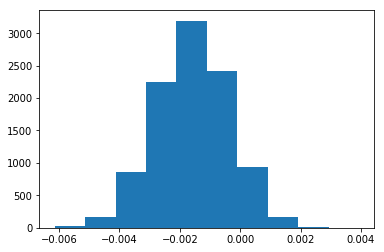

In [31]:
# Per instructions, plot a histogram of p_diffs.  As expected, this is a normal distribution:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [32]:
# Calculate the observed difference between the new and old page:
obs_diff = (df2.query('landing_page == "new_page"').converted.mean() -
            df2.query('landing_page == "old_page"').converted.mean())
obs_diff

-0.0015782389853555567

Proportion greater:  0.9061


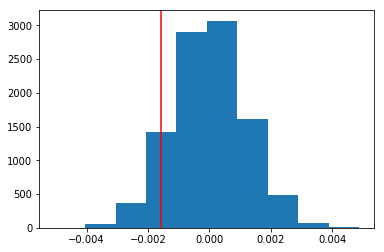

In [33]:
# Using the technique we learned in the Hypothesis Testing/Case Study - A/B Tests:
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)
plt.hist(null_vals)
plt.axvline(x=obs_diff, color='red');

# Calculate p-value from simulating draws from the normal distribution:
pvalres = (null_vals > obs_diff).mean()
print(f'Proportion greater:  {pvalres}')

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Put your answer here:**
> In part j, a p-value was computed.

> The p-value helps us determine if we retain or reject the null hypothesis ($H_0$).  To reject $H_0$ with a Type I error rate of 5%, p would have to be > 0.95.  Since it's 0.9061, we fail to reject the null.  We find the (alternate) new page is not more effective at generating conversions.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [34]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" & converted == 1').converted.count()
convert_new = df2.query('landing_page == "new_page" & converted == 1').converted.count()
n_old = df2.query('landing_page == "old_page"').converted.count()
n_new = df2.query('landing_page == "new_page"').converted.count()

convert_old, convert_new, n_old, n_new

c:\program files (x86)\python36-32\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [35]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], 0, 'smaller')
# z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new])
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

In [36]:
from scipy.stats import norm

# Tells us how significant our z-score is and what it would have to exceed to reject the null:
norm.cdf(z_score), norm.ppf(1 - 0.05)

(0.9050583127590245, 1.6448536269514722)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here:**
> The values indicate we fail to reject the null.  To reject the null, the z-score would have to be greater than 1.645 and the p-value greater than 0.95 (with a Type I error rate of 5%).  However, the z-score is only 1.311 and the p-value 0.9051.  Thus the null prevails over the alternate.

> Comparing the two methods to find the p-value, the results are close:  0.9061 vs. 0.9051.  They both reach the same conclusion - retain the null.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here:**
> This aligns well with a Logistic Regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [38]:
df2['intercept'] = 1

df2[['control', 'ab_page']] = pd.get_dummies(df2.group)

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [39]:
# Work around for a bug in statsmodels:
# See:  https://github.com/statsmodels/statsmodels/issues/3931
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

logit_mod = sm.Logit(df2.converted, df2[['intercept', 'ab_page']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 21 May 2018   Pseudo R-squ.:               8.077e-06
Time:                        07:26:26   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [40]:
np.exp(-0.0150), 1/np.exp(-0.0150)

(0.9851119396030626, 1.015113064615719)

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Put your answer here:**
> The p-value is 0.190.  The value differs because we used a different prediction technique (logistic regression) from the previous section (sampling distribution from bootstrapping).

> In the previous section, a one-tailed hypothesis test was used.  The goal was to see if the difference in means was greater than 0 (directional test).  This resulted in a p-value of 0.905.  In this section, we used a regression approach.  Regression uses a two-tailed hypothesis test.  This tells us if the alternate is statistically different from the null (non-directional).  This resulted in a p-value of 0.19.  This can be split into "two tails" using:  (1 - 0.19)/2 = +/-0.095.  Therefore if we look at just one of the tails, the p-values from the different tests are actually pretty close.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here:**
> If additional data could be collected, other things worth considering would include how many times the user visits, average reading duration, time of day, day of week, and country of origin.

> From reading StackExchange, adding more terms into the model can require additional events.  However, given the relatively large number of events in the source CSV file it shouldn't pose a problem.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [41]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [42]:
df_new.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [43]:
### Create the necessary dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new.country)

In [44]:
logit_mod = sm.Logit(df_new.converted, df_new[['intercept', 'UK', 'US']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 21 May 2018   Pseudo R-squ.:               1.521e-05
Time:                        07:28:09   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

In [45]:
np.exp(0.0507), np.exp(0.0408)

(1.052007243765014, 1.0416437559600236)

> The impact of the country of origin seems to be pretty small - about 4 to 5%.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [46]:
### Fit Your Linear Model And Obtain the Results
# I don't believe there is a difference between page and the group since the dataset was wrangled
# to make sure these match.  However, per the instructions I will do it anyway:
df_new[['new_page', 'old_page']] = pd.get_dummies(df_new.landing_page)

In [47]:
(df_new.ab_page == df_new.new_page).mean()

1.0

In [48]:
logit_mod = sm.Logit(df_new.converted, df_new[['intercept', 'new_page', 'UK', 'US']])
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 21 May 2018   Pseudo R-squ.:               2.323e-05
Time:                        07:28:29   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
new_page      -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [49]:
np.exp(-0.0149), 1/np.exp(-0.0149)

(0.9852104557227469, 1.0150115583846535)

> Including both the new page and the country of origin doesn't appear to change the results.  The new page seems to reduce the conversion rate by a little over 1%.  This result is nearly identical to the previous one without including the country of origin.

> Based on the results, the recommendation would be to keep the original page.

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by beginning the next module in the program.